# Spectrum Data Science Interview Project
## An Analysis of the 4chan Ecosystem
By Justin Law

### Introduction

4chan is an anonymous image based discussion board with separate channels for various topics. The website has been responsible for starting pranks, memes and political movements. Today, despite its many notoriety, 4chan is considered a backbone of internet subculture.

This was my first ever data science project and I consulted many resources online on the data science life cycle. I have included the sources that I learned from at the end of the notebook. Overall, it was tough to figure out how to complete the data gathering and analysis tasks and at the same time learn the various tools, skills and libraries used for this project.  However, I found it highly rewarding to view analytical information about the data that I was able to extract myself. If I had more time, I would have learned more about sentiment analysis, modelling and text generation and applied it to this dataset.


### Problem Statement
For this project, I will be selecting four channels, Technology (/g/), TV & Film (/tv/), Food & Cooking (/ck/), and Literature (/lit/) to gather discussion data to perform exporatory and discriminative analysis on language of the users on the platform.

## Data Gathering and Cleaning

I used 4chan's public API to gather the comment text and metadata of about 80 of the most recent post and reply comments on each of four channels described above. I then cleaned up the data by punctuation, numbers and other uninteresting or irrelevant and symbols. I used the bag-of-words technique to organize and later analyze the comments made by each channel. The code can be easily extended to add new channels by adding channel name and API URL to the channels and urls lists. 

In [293]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

# Channel names
channels = ['Technology', 'TV & Film', 'Food & Cooking', "Literature"]

# URLs of transcripts in scope
urls = ['https://a.4cdn.org/g/catalog.json',
        'https://a.4cdn.org/tv/catalog.json',
        'https://a.4cdn.org/ck/catalog.json',
        'https://a.4cdn.org/lit/catalog.json']

# Initialize raw data list
my_data = [[] for i in range(len(channels))]

# Pull json data from URLs
for i, c in enumerate(urls):
    response = requests.get(c)
    response_text = response.text
    my_data[i] = json.loads(response_text)

# Initialize comment list for each channel
comments = [[] for i in range(len(channels))]

# Initialize list of number of replies in each channel
replies = [0] * len(channels)

# Parse data for all comments and replies
# Each comments list element has the comments for each channel
# Replies list has each element as the total number of replies in each channel
for i in range(len(my_data)):
    for thread in my_data[i][0]["threads"]:
        if "com" in thread:
            comments[i].append(thread["com"])
        if "replies" in thread:
            replies[i] += thread["replies"]
        if "last_replies" in thread:
            for reply in thread["last_replies"]:
                if "com" in reply:
                    comments[i].append(reply["com"])
                    
data_organized = dict()

# Converts the list of lists into a dictionary
for i, c in enumerate(channels):
    data_organized[c] = comments[i]

In [294]:
# Convert the data to key: channel, string: comments format
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text


data_combined = {key: [combine_text(value)] for (key, value) in data_organized.items()}

In [295]:
# Rearrange the data into a pandas dataframe
import pandas as pd
pd.set_option('max_colwidth',150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['comments']
data_df = data_df.sort_index()
data_df

,comments
Food & Cooking,"<span class=""quote"">&gt;Yeah, I&#039;ll take an octuple bypass, extra bacon and mayonnaise</span><br><span class=""quote"">&gt;can I also get some o..."
Literature,"/lit/ is for the discussion of literature, specifically books (fiction &amp; non-fiction), short stories, poetry, creative writing, etc. If you wa..."
TV & Film,"Snyder threads being slid<br>6 minutes for it to be archived <span class=""quote"">&gt;newfag monkey thinks it can reply directly to my post</span> ..."
Technology,This board is for the discussion of technology and related topics.<br> <br> \nReminder that instigating OR participating in flame/brand wars will ...


In [296]:
# Apply text cleaning, removing punctuation, text formatting and other irrelevant symbols
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

clean = lambda x: clean_text(x)

# Let's take a look at the cleaned text
data_clean = pd.DataFrame(data_df.comments.apply(clean))
data_clean

,comments
Food & Cooking,span classquotegtyeah take an octuple bypass extra bacon and mayonnaisespanbrspan classquotegtcan i also get some onion rings a coronary dog and ...
Literature,lit is for the discussion of literature specifically books fiction amp nonfiction short stories poetry creative writing etc if you want to discuss...
TV & Film,snyder threads being minutes for it to be archived span classquotegtnewfag monkey thinks it can reply directly to my postspan a you the jew tha...
Technology,this board is for the discussion of technology and related topicsbr br reminder that instigating or participating in flamebrand wars will result i...


## Exploratory Analysis
I now begin looking at the most common words, messages per thread and other information that may be interesting.

In [297]:
# create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.comments)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaawbraaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaawbraaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah,ability,able,absolute,absolutely,abstain,academic,accept,accesible,access,...,yes,yesterday,yo,yogurt,yolks,young,zennon,zero,zombie,zulfikar
Food & Cooking,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0
Literature,0,1,1,0,0,1,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1
TV & Film,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,0
Technology,0,0,2,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [298]:
# Find the top 30 words of each channel
data = data_dtm.transpose()


top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'Food & Cooking': [('like', 11),
  ('food', 11),
  ('pork', 8),
  ('just', 8),
  ('time', 6),
  ('fries', 5),
  ('make', 5),
  ('shit', 4),
  ('endangered', 4),
  ('drink', 4),
  ('beef', 4),
  ('eat', 4),
  ('want', 4),
  ('thread', 4),
  ('meat', 4),
  ('hours', 4),
  ('soup', 4),
  ('anon', 4),
  ('ragu', 4),
  ('man', 4),
  ('hour', 3),
  ('liver', 3),
  ('hell', 3),
  ('need', 3),
  ('probably', 3),
  ('cooking', 3),
  ('street', 3),
  ('nigger', 3),
  ('know', 3),
  ('learn', 3)],
 'Literature': [('reason', 10),
  ('book', 8),
  ('read', 8),
  ('animals', 7),
  ('like', 7),
  ('animal', 6),
  ('did', 6),
  ('lit', 6),
  ('really', 5),
  ('books', 5),
  ('people', 5),
  ('think', 4),
  ('bible', 4),
  ('rights', 4),
  ('fuck', 4),
  ('good', 3),
  ('know', 3),
  ('philosophy', 3),
  ('canon', 3),
  ('deserve', 3),
  ('related', 3),
  ('chickens', 3),
  ('works', 3),
  ('use', 3),
  ('just', 3),
  ('reading', 3),
  ('got', 3),
  ('order', 3),
  ('history', 3),
  ('feelings', 3)],


### Most Common Words
I have printed out the 15 most common words in each channel. Keep in mind the many "filler" words common to many of the channels, such as "like", "just" and "use". When looking at the differences between the channels, they will be removed.

In [299]:
# Print the top 15 words of each channel
for channel, top_words in top_dict.items():
    print(channel)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

Food & Cooking
like, food, pork, just, time, fries, make, shit, endangered, drink, beef, eat, want, thread
---
Literature
reason, book, read, animals, like, animal, did, lit, really, books, people, think, bible, rights
---
TV & Film
just, people, span, godzilla, got, watch, like, live, black, lot, did, shows, know, shit
---
Technology
like, classquotegtrecommended, want, shit, just, better, gaming, span, nuclear, code, make, start, use, need
---


### Thread Replies
I looked at the total number of replies in each of the channels to possibly look at the user engagement in each of the channels.

In [300]:
#converts the list of reply values into a dictionary
reply_data = dict()

for i, c in enumerate(channels):
    reply_data[c] = replies[i]
    
pd.set_option('max_colwidth',150)

reply_df = pd.DataFrame(reply_data, index=['Replies'])
reply_df_transposed = reply_df.transpose()
reply_df_transposed

,Replies
Technology,1196
TV & Film,957
Food & Cooking,550
Literature,493


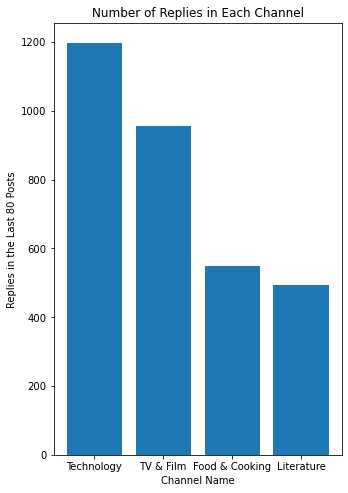

In [301]:
#plot the data as a bar chart
myFig = plt.figure(figsize=(4,6))
ax = myFig.add_axes([0,0,1,1])
ax.bar(channels,replies)
ax.set_title('Number of Replies in Each Channel')
ax.set_ylabel('Replies in the Last 80 Posts')
ax.set_xlabel('Channel Name')
plt.show()

## Discriminative Analysis
I looked looked at the most common top words between each channel and removed them to find the unique words of each channel. Using the list of unique words and the frequency of those words, I created a wordcloud to present the data visually.

In [302]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words in each channel
words = []
for channel in data.columns:
    top = [word for (word, count) in top_dict[channel]]
    for t in top:
        words.append(t)

# Let's aggregate this list and identify the most common words along with how many channels they occur in
Counter(words).most_common()

[('like', 4),
 ('just', 4),
 ('know', 4),
 ('make', 3),
 ('shit', 3),
 ('need', 3),
 ('people', 3),
 ('think', 3),
 ('want', 2),
 ('did', 2),
 ('good', 2),
 ('use', 2),
 ('got', 2),
 ('span', 2),
 ('used', 2),
 ('food', 1),
 ('pork', 1),
 ('time', 1),
 ('fries', 1),
 ('endangered', 1),
 ('drink', 1),
 ('beef', 1),
 ('eat', 1),
 ('thread', 1),
 ('meat', 1),
 ('hours', 1),
 ('soup', 1),
 ('anon', 1),
 ('ragu', 1),
 ('man', 1),
 ('hour', 1),
 ('liver', 1),
 ('hell', 1),
 ('probably', 1),
 ('cooking', 1),
 ('street', 1),
 ('nigger', 1),
 ('learn', 1),
 ('reason', 1),
 ('book', 1),
 ('read', 1),
 ('animals', 1),
 ('animal', 1),
 ('lit', 1),
 ('really', 1),
 ('books', 1),
 ('bible', 1),
 ('rights', 1),
 ('fuck', 1),
 ('philosophy', 1),
 ('canon', 1),
 ('deserve', 1),
 ('related', 1),
 ('chickens', 1),
 ('works', 1),
 ('reading', 1),
 ('order', 1),
 ('history', 1),
 ('feelings', 1),
 ('godzilla', 1),
 ('watch', 1),
 ('live', 1),
 ('black', 1),
 ('lot', 1),
 ('shows', 1),
 ('movie', 1),
 ('cut

In [303]:
# If more than half of the channels have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > 2]

# Update the document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.comments)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

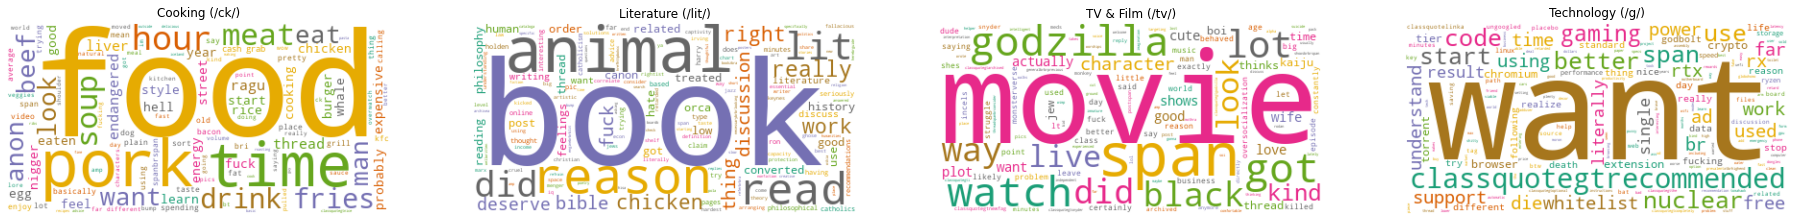

In [304]:
# Make the actual wordclouds
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [32, 12]

channel_names = ["Cooking (/ck/)", "Literature (/lit/)", "TV & Film (/tv/)", "Technology (/g/)"]

# Create subplots for each channel
for index, channel in enumerate(data.columns):
    wc.generate(data_clean.comments[channel])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(channel_names[index])
    
plt.show()

### Unique Words
Next, I look at the total number of unique words in each channel.

In [305]:
# Find the number of unique words of each channel

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for channel in data.columns:
    uniques = data[channel].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(channels, unique_list)), columns=['channel', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,channel,unique_words
2,Food & Cooking,442
0,Technology,541
1,TV & Film,626
3,Literature,790


### Profanities
Lastly, I looked at the occurence of three curse words in each of the channels.

In [306]:
data_bad_words = data.transpose()[['fucking', 'fuck', 'shit']]
data_profanity = pd.concat([data_bad_words.fucking + data_bad_words.fuck, data_bad_words.shit], axis=1)
data_profanity.columns = ['f_word', 's_word']
data_profanity

,f_word,s_word
Food & Cooking,4,4
Literature,5,2
TV & Film,3,3
Technology,3,7


## Additional Questions and Possible Follow-up Studies
Given more time, I could have looked more at the metadata and linguistics of the users. Below are some other possible follow up studies.

1. Length of comment: I could have looked at the average comment length to see which channels had users more engaged in thoughtful or analytical discussion, compared to short, surface level comments.
2. Sentiment analysis: Knowing the comment length and replies per post is important, but the emotion shown by the users is just as if not more important. By looking at the incidence of positive versus negative language, we can gauge the average sentiment of each channel and of the website as a whole
3. Profane language: In addition to the two curse words I analyzed, there are many others that I chose to omit for this project.
4. Time of posting: By building a frequency histogram of the time of posting, we can judge the schedules of the average user. For example, if the number of posts during work hours were the same as that of during the night, we could hypothesize that the average user was not in regular employment.
5. Language complexity: I could look at the average vocabulary complexity of each channel and of the site as a whole to indicate the education level and tone of language on this platform.
6. Temporal changes: The data pulled is a snapshot of the most recent posts at program runtime. Therefore, we cannot see how the users change over both a single day and over multiple days. One way to address this is by increasing the sample size by pulling the data from the API once an hour and analyzing the aggregated data. In my own testing, some of the statistics, specifically number of replies, fluctuated greatly, so with a greater data size, we could look at inherent differences in the channels rather than specific posts at a point in time gathering more engagement. 

## Sources Used
https://www.w3schools.com/python/pandas/pandas_intro.asp <br>
https://jsonformatter.org/json-parser <br>
https://github.com/adashofdata/nlp-in-python-tutorial <br>
https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm <br>
https://www.youtube.com/watch?v=e60ItwlZTKM <br>
https://www.youtube.com/watch?v=9N6a-VLBa2I <br>
https://towardsdatascience.com/the-data-science-process-a19eb7ebc41b <br>